In [1]:
import torch
import deepxde as dde
import numpy as np

%cd ..
from models import FNO2d
from train_utils.datasets import MatReader, BurgersLoader
from train_utils.train_2d import train_2d_burger

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

Using backend: pytorch
Other supported backends: tensorflow.compat.v1, tensorflow, jax, paddle.
paddle supports more examples now and is recommended.


/home/tp526/neuraloperator/PI-FNO-reproduce


<h2>Load model</h2>

In [2]:
config = {"model": {
              "layers": [64] * 5, #[16, 24, 24, 32, 32],
              "modes1": [15, 12, 9, 9],
              "modes2": [15, 12, 9, 9],
              "fc_dim": 128,
              "act": "gelu",
              "num_pad": 4,  
            },
          }

In [3]:
model = FNO2d(modes1=config['model']['modes1'],
              modes2=config['model']['modes2'],
              fc_dim=config['model']['fc_dim'],
              layers=config['model']['layers'],
              act=config['model']['act']).to(device)

ckpt_path = "/home/tp526/neuraloperator/PI-FNO-reproduce/checkpoints/burgers-FDM/burgers-invisicd-data-1-pde-0-5-64-mode-15.pt"
ckpt = torch.load(ckpt_path)
model.load_state_dict(ckpt['model'])

<All keys matched successfully>

<h2>Generate Ground Truths</h2>

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.interpolate import interp1d

def solve_burgers_inviscid(u0, Nx=128, Nt=101, cfl=0.6, t_max=1.0, x_max=1.0, plot=False):
    # ---- Grid Setup ----
    t_uniform = np.linspace(0, t_max, Nt)
    x = np.linspace(0, x_max, Nx, endpoint=False)
    dx = x[1] - x[0]
    u = u0

    # ---- WENO-Z Reconstruction ----
    def weno_z_reconstruction(q):
        """
        Reconstructs state at interface i+1/2 from the Left (uL) and Right (uR).
        """
        eps = 1e-40 # Lower epsilon for WENO-Z
        
        # Stencils
        q_m2 = np.roll(q, 2)
        q_m1 = np.roll(q, 1)
        q_p1 = np.roll(q, -1)
        q_p2 = np.roll(q, -2)

        # Smoothness indicators (Beta)
        beta0 = (13/12)*(q_m2 - 2*q_m1 + q)**2 + 0.25*(q_m2 - 4*q_m1 + 3*q)**2
        beta1 = (13/12)*(q_m1 - 2*q + q_p1)**2 + 0.25*(q_m1 - q_p1)**2
        beta2 = (13/12)*(q - 2*q_p1 + q_p2)**2 + 0.25*(3*q - 4*q_p1 + q_p2)**2

        # WENO-Z global smoothness tau
        tau5 = np.abs(beta0 - beta2)

        # WENO-Z Weights (Left Interface u_{i+1/2}^-)
        # Optimal weights: d0=0.1, d1=0.6, d2=0.3
        alpha0 = 0.1 * (1 + (tau5 / (beta0 + eps))**2)
        alpha1 = 0.6 * (1 + (tau5 / (beta1 + eps))**2)
        alpha2 = 0.3 * (1 + (tau5 / (beta2 + eps))**2)
        w_sum = alpha0 + alpha1 + alpha2
        w0, w1, w2 = alpha0/w_sum, alpha1/w_sum, alpha2/w_sum

        # Polynomials
        p0 = (2*q_m2 - 7*q_m1 + 11*q)/6
        p1 = (-q_m1 + 5*q + 2*q_p1)/6
        p2 = (2*q + 5*q_p1 - q_p2)/6

        uL = w0*p0 + w1*p1 + w2*p2

        # To get uR at i+1/2, we repeat the process on the mirror image of q
        # effectively reconstructing u_{i-1/2}^+ and shifting it.
        # Mirror: indices i -> -i.
        q_rev = q[::-1] 
        # Re-calculate betas for reversed array (using same formulas)
        qr_m2 = np.roll(q_rev, 2); qr_m1 = np.roll(q_rev, 1)
        qr_p1 = np.roll(q_rev, -1); qr_p2 = np.roll(q_rev, -2)
        
        b0 = (13/12)*(qr_m2 - 2*qr_m1 + q_rev)**2 + 0.25*(qr_m2 - 4*qr_m1 + 3*q_rev)**2
        b1 = (13/12)*(qr_m1 - 2*q_rev + qr_p1)**2 + 0.25*(qr_m1 - qr_p1)**2
        b2 = (13/12)*(q_rev - 2*qr_p1 + qr_p2)**2 + 0.25*(3*q_rev - 4*qr_p1 + qr_p2)**2
        
        t5 = np.abs(b0 - b2)
        
        # Note: Weights for uR (mirror) generally map d0->d2, d1->d1, d2->d0
        # But since we reversed the array, we just apply the same "Left" logic 
        # to the reversed array and then reverse back.
        a0 = 0.1 * (1 + (t5 / (b0 + eps))**2)
        a1 = 0.6 * (1 + (t5 / (b1 + eps))**2)
        a2 = 0.3 * (1 + (t5 / (b2 + eps))**2)
        ws = a0 + a1 + a2
        
        pp0 = (2*qr_m2 - 7*qr_m1 + 11*q_rev)/6
        pp1 = (-qr_m1 + 5*q_rev + 2*qr_p1)/6
        pp2 = (2*q_rev + 5*qr_p1 - qr_p2)/6
        
        uR_rev = (a0/ws)*pp0 + (a1/ws)*pp1 + (a2/ws)*pp2
        
        # Reverse back to get u^+ at i-1/2, then roll to get u^+ at i+1/2
        uR = np.roll(uR_rev[::-1], -1)
        
        return uL, uR

    # ---- Godunov Flux ----
    def godunov_flux(uL, uR):
        fL = 0.5 * uL**2
        fR = 0.5 * uR**2
        
        F = np.zeros_like(uL)
        
        # 1. Shock case: uL > uR -> max(fL, fR)
        mask_shock = uL >= uR
        F[mask_shock] = np.maximum(fL[mask_shock], fR[mask_shock])
        
        # 2. Rarefaction case: uL < uR
        mask_rarefaction = uL < uR
        
        # Subcase: Transonic rarefaction (uL < 0 < uR) -> Flux is 0
        mask_transonic = mask_rarefaction & (uL < 0) & (uR > 0)
        
        # Subcase: Standard rarefaction -> min(fL, fR)
        mask_std_rare = mask_rarefaction & (~mask_transonic)
        
        F[mask_std_rare] = np.minimum(fL[mask_std_rare], fR[mask_std_rare])
        F[mask_transonic] = 0.0
        
        return F

    # RHS Operator
    def L(u):
        uL, uR = weno_z_reconstruction(u)
        flux_interface = godunov_flux(uL, uR)
        return -(flux_interface - np.roll(flux_interface, 1)) / dx

    # ---- Adaptive Time Stepping ----
    t = 0.0
    
    # History for interpolation
    t_hist = [t]
    u_hist = [u.copy()]

    while t < t_max:
        max_speed = np.max(np.abs(u))
        if max_speed == 0: max_speed = 1e-6
        dt = cfl * dx / max_speed
        
        if t + dt > t_max:
            dt = t_max - t

        # SSP RK3
        u1 = u + dt * L(u)
        u2 = 0.75*u + 0.25*(u1 + dt*L(u1))
        u  = (1/3)*u + (2/3)*(u2 + dt*L(u2))

        t += dt
        t_hist.append(t)
        u_hist.append(u.copy())

    # ---- Interpolate to Uniform Grid ----
    t_hist = np.array(t_hist)
    u_hist = np.array(u_hist)
    
    u_uniform = np.zeros((Nt, Nx))
    for i in range(Nx):
        u_uniform[:, i] = np.interp(t_uniform, t_hist, u_hist[:, i])

    # ---- Plotting ----
    if plot:
        plt.figure(figsize=(12,5))
        
        # 1D Final Slice
        plt.subplot(1,2,1)
        plt.plot(x, u_uniform[-1], 'r-', label="Final (WENO-Z)")
        plt.plot(x, ic(x), 'k--', label="Initial")
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.title(f"Cut at t={t_max}")

        # 2D Space-Time
        plt.subplot(1,2,2)
        plt.imshow(u_uniform, aspect='auto', origin='lower',
                   extent=[0, x_max, 0, t_max], cmap='jet')
        plt.colorbar(label="u")
        plt.xlabel("x")
        plt.ylabel("t")
        plt.title("Space-Time Evolution")

        plt.tight_layout()
        plt.show()

    return u_uniform

def create_burgers_dataset(N_SAMPLES=200, Nx=128, Nt=101, X_MUL=4, LENGTH_SCALE=1.0, ics=None):
    """
    Generates dataset and returns dictionary with NumPy arrays.
    """
    print(f"Generating {N_SAMPLES} samples of Inviscid Burgers' equation ...")
    
    # Pre-allocate arrays
    x_data = np.zeros((N_SAMPLES, Nx))      # To store Initial Conditions
    y_data = np.zeros((N_SAMPLES, Nt, Nx))  # To store Solutions

    func_space = dde.data.GRF(kernel="ExpSineSquared", length_scale=LENGTH_SCALE)
    feats = func_space.random(N_SAMPLES)

    xs = np.linspace(0, 1, Nx*X_MUL, endpoint=False)
    if ics is not None:
        ics_all = np.zeros((N_SAMPLES, Nx*X_MUL))
        # interpolate ics to match the resolution
        x_res = ics.shape[1]
        x_grid = np.linspace(0, 1, x_res+1, endpoint=True)
        for k in range(N_SAMPLES):
            ic_pad = np.append(ics[k], ics[k][0])
            ic = interp1d(x_grid, ic_pad, "linear")
            ics_all[k] = ic(xs)

    else:    
        ics_all = func_space.eval_batch(feats, xs)
    
    for i in range(N_SAMPLES):
        if (i+1) % 50 == 0:
            print(f"Processing sample {i+1}/{N_SAMPLES}...")
            
        # 1. Generate IC
        u0 = ics_all[i]
        
        # 2. Solve
        u_sol = solve_burgers_inviscid(u0, Nx=Nx*X_MUL, Nt=Nt, cfl=0.5)
        
        # 3. Store
        x_data[i] = u0[::X_MUL]
        y_data[i] = u_sol[:, ::X_MUL]

    # 4. Pack into dictionary (NumPy arrays only)
    burgers_128 = {
        'x': x_data,
        'y': y_data,
        'visc': np.array([[0]])
    }
    
    print("\nGeneration complete.")
    print(f"x shape: {burgers_128['x'].shape}")
    print(f"y shape: {burgers_128['y'].shape}")
    
    return burgers_128

Generating 300 samples of Inviscid Burgers' equation ...
Processing sample 50/300...
Processing sample 100/300...
Processing sample 150/300...
Processing sample 200/300...
Processing sample 250/300...
Processing sample 300/300...

Generation complete.
x shape: (300, 128)
y shape: (300, 101, 128)


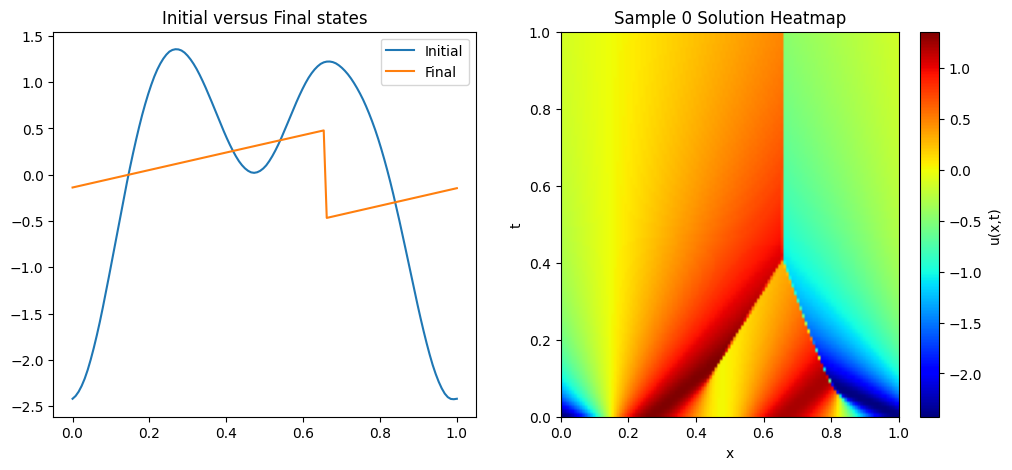

In [20]:
# --- Example Usage ---
if __name__ == "__main__":
    ics = np.load("/home/tp526/Characteristics/Characteristics-Net/Results/test_data/burgers_ic_grf_1.0_1000.npy")

    # Generate data
    data_dict = create_burgers_dataset(N_SAMPLES=300, Nx=128, Nt=101, X_MUL=2, ics=ics)
    
    # Verification Plot
    sample_idx = np.random.randint(1)
    x_grid = np.linspace(0, 1, 128)
    u_field = data_dict['y'][sample_idx]
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)    
    plt.plot(x_grid, u_field[0], label="Initial")
    plt.plot(x_grid, u_field[-1], label="Final")
    plt.title("Initial versus Final states")
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.imshow(u_field, extent=[0, 1, 0, 1], origin="lower", aspect="auto", cmap="jet")
    plt.colorbar(label="u(x,t)")
    plt.title(f"Sample {sample_idx} Solution Heatmap")
    plt.xlabel("x")
    plt.ylabel("t")
    plt.show()

<h2>Test the model</h2>

In [15]:
# Load the test data
import scipy.io

# Load the file
mat_data = scipy.io.loadmat('/home/tp526/Characteristics/data/test_data/burgers_truth_x100_t101_1000.mat')

# View the keys (variable names) inside the file
print(mat_data.keys())

# Access a specific variable (e.g., if you had a variable named 'my_array')
data_dict = {
    'x' : mat_data['input'],
    'y' : mat_data['output'],
    'visc' : mat_data['visc']
}

dict_keys(['__header__', '__version__', '__globals__', 'input', 'output', 'visc'])


In [15]:
def format_burgers_data(data_dict):
    """
    Reshapes the Burgers dataset into a coordinate-based format.
    
    Args:
        data_dict (dict): Dictionary with keys 'x' (N, Nx) and 'y' (N, Nt, Nx).
        
    Returns:
        np.array: A single array of shape (N_SAMPLES, Nt, Nx, 3).
                  Channel 0: u0(x) repeated over time
                  Channel 1: x coordinates
                  Channel 2: t coordinates
    """
    # 1. Extract dimensions
    # data_dict['x'] is the initial condition u0, shape (N, Nx)
    # data_dict['y'] is the solution u, shape (N, Nt, Nx)
    u0 = data_dict['x'] 
    N_samples, Nx = u0.shape
    Nt = data_dict['y'].shape[1]
    
    print(f"Dimensions detected: N={N_samples}, Nt={Nt}, Nx={Nx}")

    # 2. Create Mesh Grids (Nt, Nx)
    # Recreate the grids used in the solver
    x_1d = np.linspace(0, 1, Nx, endpoint=False)
    t_1d = np.linspace(0, 1, Nt)
    
    # Create 2D grids. indexing='ij' ensures output is (Nt, Nx)
    # T_grid varies along axis 0, X_grid varies along axis 1
    T_grid, X_grid = np.meshgrid(t_1d, x_1d, indexing='ij')
    
    # 3. Broadcast/Repeat Arrays to shape (N, Nt, Nx)
    
    # Channel 0: u0 (Initial Condition)
    # Input: (N, Nx) -> Expand to (N, 1, Nx) -> Tile to (N, Nt, Nx)
    u0_expanded = np.tile(u0[:, None, :], (1, Nt, 1))
    
    # Channel 1: X Grid
    # Input: (Nt, Nx) -> Expand to (1, Nt, Nx) -> Broadcast to (N, Nt, Nx)
    X_expanded = np.tile(X_grid[None, :, :], (N_samples, 1, 1))
    
    # Channel 2: T Grid
    # Input: (Nt, Nx) -> Expand to (1, Nt, Nx) -> Broadcast to (N, Nt, Nx)
    T_expanded = np.tile(T_grid[None, :, :], (N_samples, 1, 1))
    
    # 4. Stack along the last axis
    # Result shape: (N, Nt, Nx, 3, 1)
    formatted_data = np.stack([u0_expanded, X_expanded, T_expanded], axis=-1)
    
    return formatted_data

In [22]:
formatted_inputs = format_burgers_data(data_dict)
formatted_inputs.shape

Dimensions detected: N=300, Nt=101, Nx=128


(300, 101, 128, 3)

In [23]:
#model.eval()

N_CASE = formatted_inputs.shape[0]

l2_errors = np.zeros(N_CASE)
l1_errors = np.zeros(N_CASE)

with torch.no_grad():
    for k in range(N_CASE):
        x = torch.tensor(formatted_inputs[k:k+1], dtype=torch.float32).to(device)
        y = torch.tensor(data_dict["y"][k:k+1], dtype=torch.float32).to(device)

        out = model(x).reshape(y.shape)

        # Relative L2
        l2 = torch.norm(out - y, p=2) / torch.norm(y, p=2)
        l2_errors[k] = l2.item()

        # Relative L1
        l1 = torch.norm(out - y, p=1) / torch.norm(y, p=1)
        l1_errors[k] = l1.item()

        if (k+1) % 50 == 0:
            print(f'Sample {k+1}/{N_CASE}: ')
            print(f'    Mean L2-relative-error: {np.mean(l2_errors[:(k+1)]):.6e}')
            print(f'    Mean L1-relative-error: {np.mean(l1_errors[:(k+1)]):.6e}')
            print("-" * 50 + "\n")

print(f"Mean L2-relative-error over 1000 tests: {np.mean(l2_errors):.6e}")
print(f"Mean L1-relative-error over 1000 tests: {np.mean(l1_errors):.6e}")
print(f"L2 std: {np.std(l2_errors):.6e}")
print(f"L1 std: {np.std(l1_errors):.6e}")


Sample 50/300: 
    Mean L2-relative-error: 1.083818e-01
    Mean L1-relative-error: 3.276329e-02
--------------------------------------------------

Sample 100/300: 
    Mean L2-relative-error: 1.133517e-01
    Mean L1-relative-error: 3.522928e-02
--------------------------------------------------

Sample 150/300: 
    Mean L2-relative-error: 1.145853e-01
    Mean L1-relative-error: 3.470584e-02
--------------------------------------------------

Sample 200/300: 
    Mean L2-relative-error: 1.113113e-01
    Mean L1-relative-error: 3.337690e-02
--------------------------------------------------

Sample 250/300: 
    Mean L2-relative-error: 1.116533e-01
    Mean L1-relative-error: 3.389533e-02
--------------------------------------------------

Sample 300/300: 
    Mean L2-relative-error: 1.102283e-01
    Mean L1-relative-error: 3.362859e-02
--------------------------------------------------

Mean L2-relative-error over 1000 tests: 1.102283e-01
Mean L1-relative-error over 1000 tests: 3.

In [21]:
np.min(l1_errors)

np.float64(0.013536940328776836)

In [ ]:
#

Input shape:  torch.Size([1, 101, 128, 3])
Output shape:  torch.Size([1, 101, 128])


==Relative L1 error mean:  0.037682==

Ground Truth


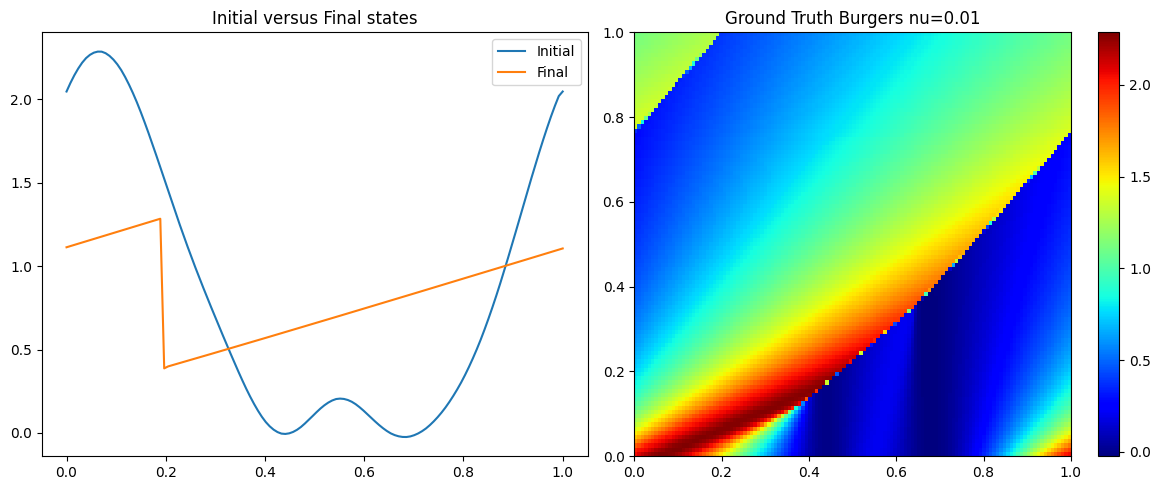

Prediction


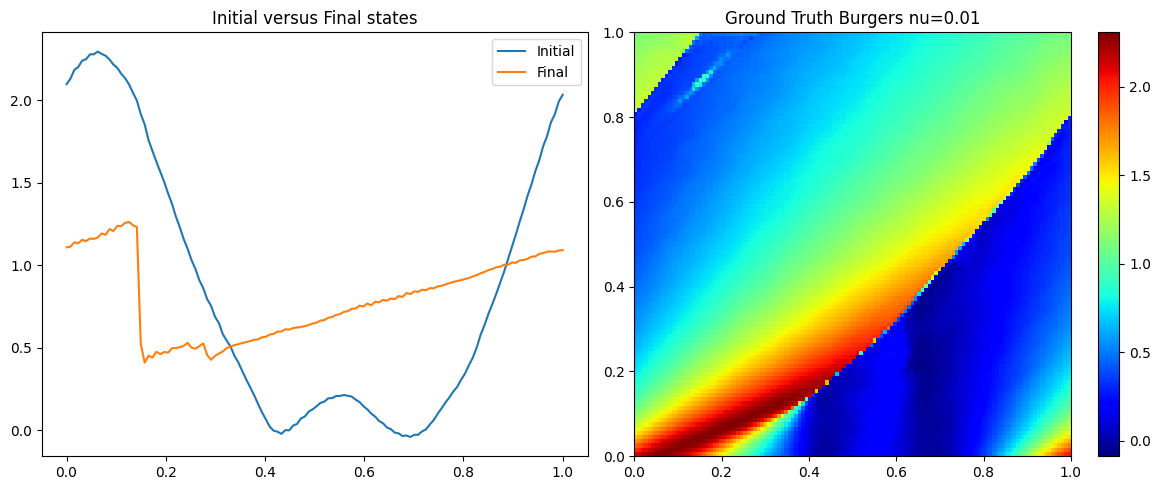

In [14]:
import matplotlib.pyplot as plt

k = np.random.randint(1000)

x, y = torch.tensor(formatted_inputs[k:k+1], dtype=torch.float32).to(device), torch.tensor(data_dict["y"][k:k+1], dtype=torch.float32).to(device)

print("Input shape: ", x.shape)
print("Output shape: ", y.shape)
print("\n")

out = model(x).reshape(y.shape)

data_loss = torch.norm(out - y, p=1) / torch.norm(y, p=1)

print(f'==Relative L1 error mean: {data_loss.item() : .6f}==\n')

# Plot
print("Ground Truth")
truth = y[0].detach().cpu().numpy()
x_grid = np.linspace(0, 1, truth.shape[1])

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_grid, truth[0], label="Initial")
plt.plot(x_grid, truth[-1], label="Final")
plt.title("Initial versus Final states")
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(truth, extent=[0, 1, 0, 1], origin="lower", aspect="auto", cmap="jet")
plt.title("Ground Truth Burgers nu=0.01")
plt.colorbar()

plt.tight_layout()
plt.show()

print("Prediction")
pred = out[0].detach().cpu().numpy()

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(x_grid, pred[0], label="Initial")
plt.plot(x_grid, pred[-1], label="Final")
plt.title("Initial versus Final states")
plt.legend()

plt.subplot(1, 2, 2)
plt.imshow(pred, extent=[0, 1, 0, 1], origin="lower", aspect="auto", cmap="jet")
plt.title("Ground Truth Burgers nu=0.01")
plt.colorbar()

plt.tight_layout()
plt.show()



In [31]:
dataset = BurgersLoader("/home/tp526/neuraloperator/data/burgers_pino.mat",
                            nx=128, nt=100,
                            sub=1, sub_t=1, new=True)
train_loader = dataset.make_loader(n_sample=10,
                                    batch_size=1,
                                    start=0)

/home/tp526/.conda/envs/dde/lib/python3.11/site-packages/scipy/io/matlab/_mio.py:235: MatReadWarning: Duplicate variable name "None" in stream - replacing previous with new
Considerscipy.io.matlab.varmats_from_mat to split file into single variable files
  matfile_dict = MR.get_variables(variable_names)


In [32]:
for batch in train_loader:
    x, y = batch
    print(x.shape)

torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])
torch.Size([1, 101, 128, 3])


In [38]:
import scipy

# We map 'x' -> 'input' and 'y' -> 'output'
mat_data = {
    'input': data_dict['x'],
    'output': data_dict['y'],
    'visc': data_dict['visc']
}

# 3. Save to .mat file
# do_compression=True helps if the arrays are large
scipy.io.savemat('/home/tp526/neuraloperator/data/test_data/burgers_truth_x128_t101_1000.mat', mat_data, do_compression=True)

print("Saved to /home/tp526/neuraloperator/data/test_data/burgers_truth_x128_t101_1000.mat")

Saved to /home/tp526/neuraloperator/data/test_data/burgers_truth_x128_t101_1000.mat


In [19]:
print("-" * 100)
print("\nNumber of trainable parameters: ", sum(p.numel() for p in model.parameters()))
print("\n" + "-" * 100)

----------------------------------------------------------------------------------------------------

Number of trainable parameters:  4383489

----------------------------------------------------------------------------------------------------


<h2>Relatve Errors on a snapshot t = 0.65</h2>

In [24]:
#model.eval()

N_CASE = formatted_inputs.shape[0]

l2_errors_snapshot = np.zeros(N_CASE)
l1_errors_snapshot = np.zeros(N_CASE)

with torch.no_grad():
    for k in range(N_CASE):
        x = torch.tensor(formatted_inputs[k:k+1], dtype=torch.float32).to(device)
        y = torch.tensor(data_dict["y"][k:k+1], dtype=torch.float32).to(device)

        out = model(x).reshape(y.shape)

        y = y[:, 65]
        out = out[:, 65]

        # Relative L2
        l2 = torch.norm(out - y, p=2) / torch.norm(y, p=2)
        l2_errors_snapshot[k] = l2.item()

        # Relative L1
        l1 = torch.norm(out - y, p=1) / torch.norm(y, p=1)
        l1_errors_snapshot[k] = l1.item()

        if (k+1) % 50 == 0:
            print(f'Sample {k+1}/{N_CASE}: ')
            print(f'    Mean L2-relative-error: {np.mean(l2_errors_snapshot[:(k+1)]):.6e}')
            print(f'    Mean L1-relative-error: {np.mean(l1_errors_snapshot[:(k+1)]):.6e}')
            print("-" * 50 + "\n")

print(f"Mean L2-relative-error over 1000 tests: {np.mean(l2_errors_snapshot):.6e}")
print(f"Mean L1-relative-error over 1000 tests: {np.mean(l1_errors_snapshot):.6e}")
print(f"L2 std: {np.std(l2_errors_snapshot):.6e}")
print(f"L1 std: {np.std(l1_errors_snapshot):.6e}")


Sample 50/300: 
    Mean L2-relative-error: 1.372627e-01
    Mean L1-relative-error: 4.122561e-02
--------------------------------------------------

Sample 100/300: 
    Mean L2-relative-error: 1.406940e-01
    Mean L1-relative-error: 4.474593e-02
--------------------------------------------------

Sample 150/300: 
    Mean L2-relative-error: 1.373616e-01
    Mean L1-relative-error: 4.247451e-02
--------------------------------------------------

Sample 200/300: 
    Mean L2-relative-error: 1.364072e-01
    Mean L1-relative-error: 4.113942e-02
--------------------------------------------------

Sample 250/300: 
    Mean L2-relative-error: 1.406036e-01
    Mean L1-relative-error: 4.233231e-02
--------------------------------------------------

Sample 300/300: 
    Mean L2-relative-error: 1.368467e-01
    Mean L1-relative-error: 4.203543e-02
--------------------------------------------------

Mean L2-relative-error over 1000 tests: 1.368467e-01
Mean L1-relative-error over 1000 tests: 4.

In [28]:
data_dict["y"].shape

(1000, 101, 128)